In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('data/Data_Train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78458 entries, 0 to 78457
Data columns (total 11 columns):
Unique_ID     78458 non-null int64
Name          78458 non-null object
Genre         78458 non-null object
Country       78458 non-null object
Song_Name     78457 non-null object
Timestamp     78458 non-null object
Views         78458 non-null int64
Comments      78458 non-null int64
Likes         78458 non-null object
Popularity    78458 non-null object
Followers     78458 non-null int64
dtypes: int64(4), object(7)
memory usage: 6.6+ MB


In [3]:
df['Name'] = pd.factorize(df.Name)[0]
df['Genre'] = pd.factorize(df.Genre)[0]

In [4]:
df = df[['Name', 'Genre', 'Timestamp', 'Comments', 'Likes', 'Popularity', 'Followers', 'Views']]

In [5]:
def cleaner(x):
    if ',' in x:
        x = x.replace(',', '')
    elif 'M' in x:
        x = float(x.replace('M', ''))
        x = x*10**6
    elif 'K' in x:
        x = float(x.replace('K', ''))
        x = x*10**3
    return float(x)

In [6]:
df.Likes = df.Likes.apply(lambda x: cleaner(x))
df.Popularity = df.Popularity.apply(lambda x: cleaner(x))

In [7]:
#df.columns = df.columns.str.lower()
df.columns = map(str.lower, df.columns)

In [8]:
df['timestamp'] = pd.to_datetime(df.timestamp)

In [9]:
from datetime import datetime
df['year'] = df.timestamp.dt.year
df['month'] = df.timestamp.dt.month
df['day'] = df.timestamp.dt.day
df['day_of_year'] = df.timestamp.dt.dayofyear
df['day_of_week'] = df.timestamp.dt.dayofweek
df['is_weekend'] = (df.timestamp.dt.weekday>=5).astype(int)
df['week'] = df.timestamp.dt.week
df['days_since_release'] = (datetime.now() - df.timestamp).dt.days
df['engagement'] = df.likes + df.comments
df['engagement_ratio'] = df['engagement'] / df['followers']

In [10]:
df.columns

Index(['name', 'genre', 'timestamp', 'comments', 'likes', 'popularity',
       'followers', 'views', 'year', 'month', 'day', 'day_of_year',
       'day_of_week', 'is_weekend', 'week', 'days_since_release', 'engagement',
       'engagement_ratio'],
      dtype='object')

In [30]:
X = df[['name', 'genre', 'comments', 'likes', 'popularity',
       'followers', 'year', 'month', 'day', 'day_of_year',
       'day_of_week', 'is_weekend', 'week', 'days_since_release',
       'engagement']]
y = df['views']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

In [12]:
X_train.head()

,name,genre,comments,likes,popularity,followers,year,month,day,day_of_year,day_of_week,is_weekend,week,days_since_release,engagement,engagement_ratio
71785,89,5,4,59.0,12.0,165268,2014,3,14,73,4,0,11,2162,63.0,0.000381
42292,54,4,96,143.0,91.0,6084,2018,7,26,207,3,0,30,568,239.0,0.039283
55016,412,3,0,6.0,2.0,342,2019,1,23,23,2,0,4,386,6.0,0.017544
50270,75,0,2,85.0,29.0,29446,2014,9,10,253,2,0,37,1982,87.0,0.002955
54582,324,3,435,2839.0,684.0,106971,2018,2,5,36,0,0,6,738,3274.0,0.030606


In [13]:
clf = LinearRegression(normalize=True)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)

print(np.sqrt(mean_squared_error(y_val, y_pred)))
print(mean_squared_error(y_val, y_pred))

#without engagement ratio
#789180.988643476
#622806632836.2943

#with engagement ratio
#601527.5878659646
#361835438963.84576

721911.6698457112
521156459059.4232


In [14]:
rf = RandomForestRegressor()

rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)

print(np.sqrt(mean_squared_error(y_val, y_pred)))
print(mean_squared_error(y_val, y_pred))

#without engagement ratio
#767096.827670948
#588437543022.8322

#leaderboardscore : 827580.07742

#with engagement ratio
#496282.4861702416
#246296306079.31604

711707.5566895821
506527646249.05475


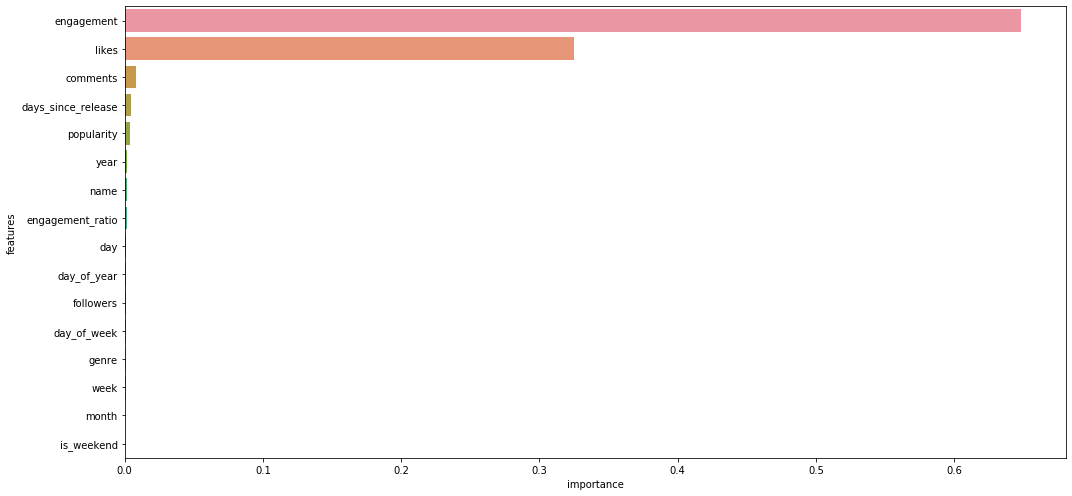

In [15]:
import seaborn as sns
feature_importance = pd.DataFrame(sorted(zip(X_train.columns, rf.feature_importances_), reverse=True), columns=['features', 'importance'])
plt.figure(figsize=(15,7))
sns.barplot(y='features', x='importance', data=feature_importance.sort_values(by='importance', ascending=False))
plt.tight_layout()

In [20]:
import xgboost as xgb

xgb = xgb.XGBRegressor()

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_val)

print(np.sqrt(mean_squared_error(y_val, y_pred)))
print(mean_squared_error(y_val, y_pred))

#leaderboard score : 751217.21271

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[05:44:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
764246.8194616248
584073201057.2094


In [60]:
import xgboost as xgb
model = xgb.XGBRegressor()


In [65]:
from sklearn.model_selection import GridSearchCV

params = {'colsample_bytree':[1,0.8,0.6],
            'gamma' : [0,3,5],
            'learning_rate' : [0.1,0.05,0.03],
            'max_depth' : [3,5,6,7],
            'n_estimator' : [100, 300, 500, 1000],
             'subsample' : [1,0.8,0.7]}

tuning_model = GridSearchCV(estimator=model, param_grid=params, scoring="neg_mean_squared_error", n_jobs=-1, cv=5,verbose=12)

In [ ]:
tuning_model.fit(X_train, y_train)

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   53.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   55.7s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  1

[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 147 tasks      | elapsed: 10.1min
[Paralle

[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed: 19.1min
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed: 19.4min
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed: 19.4min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 19.4min
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed: 19.5min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed: 19.5min
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed: 19.5min
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed: 19.6min
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed: 19.7min
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed: 19.7min
[Parallel(n_jobs=-1)]: Done 279 tasks      | elapsed: 19.7min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 19.7min
[Paralle

[Parallel(n_jobs=-1)]: Done 398 tasks      | elapsed: 27.1min
[Parallel(n_jobs=-1)]: Done 399 tasks      | elapsed: 27.1min
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed: 27.2min
[Parallel(n_jobs=-1)]: Done 401 tasks      | elapsed: 27.3min
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed: 27.4min
[Parallel(n_jobs=-1)]: Done 403 tasks      | elapsed: 27.4min
[Parallel(n_jobs=-1)]: Done 404 tasks      | elapsed: 27.5min
[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed: 34.7min
[Parallel(n_jobs=-1)]: Done 406 tasks      | elapsed: 34.8min
[Parallel(n_jobs=-1)]: Done 407 tasks      | elapsed: 34.8min
[Parallel(n_jobs=-1)]: Done 408 tasks      | elapsed: 34.8min
[Parallel(n_jobs=-1)]: Done 409 tasks      | elapsed: 35.0min
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed: 35.0min
[Parallel(n_jobs=-1)]: Done 411 tasks      | elapsed: 35.0min
[Parallel(n_jobs=-1)]: Done 412 tasks      | elapsed: 35.1min
[Parallel(n_jobs=-1)]: Done 413 tasks      | elapsed: 35.3min
[Paralle

[Parallel(n_jobs=-1)]: Done 531 tasks      | elapsed: 43.5min
[Parallel(n_jobs=-1)]: Done 532 tasks      | elapsed: 43.6min
[Parallel(n_jobs=-1)]: Done 533 tasks      | elapsed: 43.6min
[Parallel(n_jobs=-1)]: Done 534 tasks      | elapsed: 43.6min
[Parallel(n_jobs=-1)]: Done 535 tasks      | elapsed: 43.7min
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed: 43.8min
[Parallel(n_jobs=-1)]: Done 537 tasks      | elapsed: 43.8min
[Parallel(n_jobs=-1)]: Done 538 tasks      | elapsed: 43.8min
[Parallel(n_jobs=-1)]: Done 539 tasks      | elapsed: 43.9min
[Parallel(n_jobs=-1)]: Done 540 tasks      | elapsed: 43.9min
[Parallel(n_jobs=-1)]: Done 541 tasks      | elapsed: 44.1min
[Parallel(n_jobs=-1)]: Done 542 tasks      | elapsed: 44.1min
[Parallel(n_jobs=-1)]: Done 543 tasks      | elapsed: 44.1min
[Parallel(n_jobs=-1)]: Done 544 tasks      | elapsed: 44.2min
[Parallel(n_jobs=-1)]: Done 545 tasks      | elapsed: 44.3min
[Parallel(n_jobs=-1)]: Done 546 tasks      | elapsed: 44.3min
[Paralle

[Parallel(n_jobs=-1)]: Done 664 tasks      | elapsed: 53.1min
[Parallel(n_jobs=-1)]: Done 665 tasks      | elapsed: 53.4min
[Parallel(n_jobs=-1)]: Done 666 tasks      | elapsed: 53.4min
[Parallel(n_jobs=-1)]: Done 667 tasks      | elapsed: 53.5min
[Parallel(n_jobs=-1)]: Done 668 tasks      | elapsed: 53.6min
[Parallel(n_jobs=-1)]: Done 669 tasks      | elapsed: 53.7min
[Parallel(n_jobs=-1)]: Done 670 tasks      | elapsed: 53.8min
[Parallel(n_jobs=-1)]: Done 671 tasks      | elapsed: 53.9min
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed: 53.9min
[Parallel(n_jobs=-1)]: Done 673 tasks      | elapsed: 54.1min
[Parallel(n_jobs=-1)]: Done 674 tasks      | elapsed: 54.2min
[Parallel(n_jobs=-1)]: Done 675 tasks      | elapsed: 54.3min
[Parallel(n_jobs=-1)]: Done 676 tasks      | elapsed: 54.3min
[Parallel(n_jobs=-1)]: Done 677 tasks      | elapsed: 54.5min
[Parallel(n_jobs=-1)]: Done 678 tasks      | elapsed: 54.6min
[Parallel(n_jobs=-1)]: Done 679 tasks      | elapsed: 54.6min
[Paralle

[Parallel(n_jobs=-1)]: Done 797 tasks      | elapsed: 62.3min
[Parallel(n_jobs=-1)]: Done 798 tasks      | elapsed: 62.3min
[Parallel(n_jobs=-1)]: Done 799 tasks      | elapsed: 62.4min
[Parallel(n_jobs=-1)]: Done 800 tasks      | elapsed: 62.4min
[Parallel(n_jobs=-1)]: Done 801 tasks      | elapsed: 62.5min
[Parallel(n_jobs=-1)]: Done 802 tasks      | elapsed: 62.6min
[Parallel(n_jobs=-1)]: Done 803 tasks      | elapsed: 62.6min
[Parallel(n_jobs=-1)]: Done 804 tasks      | elapsed: 62.7min
[Parallel(n_jobs=-1)]: Done 805 tasks      | elapsed: 62.8min
[Parallel(n_jobs=-1)]: Done 806 tasks      | elapsed: 62.9min
[Parallel(n_jobs=-1)]: Done 807 tasks      | elapsed: 62.9min
[Parallel(n_jobs=-1)]: Done 808 tasks      | elapsed: 63.0min
[Parallel(n_jobs=-1)]: Done 809 tasks      | elapsed: 63.1min
[Parallel(n_jobs=-1)]: Done 810 tasks      | elapsed: 63.1min
[Parallel(n_jobs=-1)]: Done 811 tasks      | elapsed: 63.2min
[Parallel(n_jobs=-1)]: Done 812 tasks      | elapsed: 63.2min
[Paralle

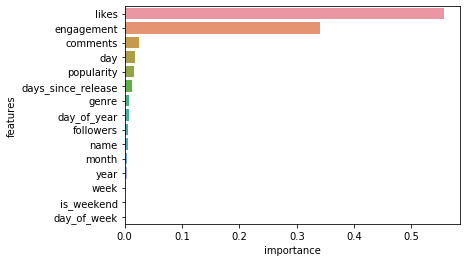

In [28]:
feature_importance = pd.DataFrame(sorted(zip(xgb.feature_importances_, X_train.columns), reverse=True), 
                                  columns=['importance', 'features'])

sns.barplot(x='importance', y='features', data=feature_importance)

In [49]:
from catboost import CatBoostRegressor

cbr = CatBoostRegressor()

cbr.fit(X_train, y_train)
y_pred = cbr.predict(X_val)

print(np.sqrt(mean_squared_error(y_val, y_pred)))
print(mean_squared_error(y_val, y_pred))

#leaderboard score:1650345.15139

Learning rate set to 0.079629
0:	learn: 3658492.1399014	total: 180ms	remaining: 2m 59s
1:	learn: 3459457.8186694	total: 215ms	remaining: 1m 47s
2:	learn: 3263037.5750994	total: 239ms	remaining: 1m 19s
3:	learn: 3077925.7245436	total: 260ms	remaining: 1m 4s
4:	learn: 2906194.5990171	total: 278ms	remaining: 55.4s
5:	learn: 2751810.2013837	total: 296ms	remaining: 49s
6:	learn: 2614970.5603865	total: 312ms	remaining: 44.3s
7:	learn: 2500656.5629143	total: 330ms	remaining: 40.9s
8:	learn: 2378513.4782989	total: 346ms	remaining: 38.1s
9:	learn: 2277369.4563852	total: 363ms	remaining: 36s
10:	learn: 2174655.2739750	total: 380ms	remaining: 34.2s
11:	learn: 2083631.2539753	total: 401ms	remaining: 33s
12:	learn: 2001670.9929434	total: 421ms	remaining: 32s
13:	learn: 1926486.7266087	total: 447ms	remaining: 31.5s
14:	learn: 1861513.3656519	total: 465ms	remaining: 30.6s
15:	learn: 1807035.0629444	total: 483ms	remaining: 29.7s
16:	learn: 1751614.8045551	total: 500ms	remaining: 28.9s
17:	learn: 17022

149:	learn: 707957.4905100	total: 3.73s	remaining: 21.1s
150:	learn: 704330.3047644	total: 3.76s	remaining: 21.1s
151:	learn: 701508.1374466	total: 3.78s	remaining: 21.1s
152:	learn: 699181.0824365	total: 3.8s	remaining: 21s
153:	learn: 695107.8765427	total: 3.82s	remaining: 21s
154:	learn: 690798.9813833	total: 3.84s	remaining: 20.9s
155:	learn: 688232.3280050	total: 3.86s	remaining: 20.9s
156:	learn: 686058.6303437	total: 3.88s	remaining: 20.8s
157:	learn: 683308.2181229	total: 3.92s	remaining: 20.9s
158:	learn: 682464.8758217	total: 3.95s	remaining: 20.9s
159:	learn: 679990.2935492	total: 3.98s	remaining: 20.9s
160:	learn: 676269.9351963	total: 4.02s	remaining: 20.9s
161:	learn: 673768.3027446	total: 4.05s	remaining: 20.9s
162:	learn: 671783.8708816	total: 4.08s	remaining: 21s
163:	learn: 668602.4946323	total: 4.12s	remaining: 21s
164:	learn: 667083.4765036	total: 4.15s	remaining: 21s
165:	learn: 664215.4121476	total: 4.18s	remaining: 21s
166:	learn: 662959.8477948	total: 4.21s	rema

296:	learn: 467411.7514187	total: 7.29s	remaining: 17.3s
297:	learn: 466991.5987405	total: 7.32s	remaining: 17.2s
298:	learn: 466170.3944425	total: 7.34s	remaining: 17.2s
299:	learn: 465149.8252328	total: 7.36s	remaining: 17.2s
300:	learn: 462696.4687930	total: 7.38s	remaining: 17.1s
301:	learn: 461660.8227268	total: 7.4s	remaining: 17.1s
302:	learn: 460644.4380194	total: 7.42s	remaining: 17.1s
303:	learn: 459559.1714340	total: 7.44s	remaining: 17s
304:	learn: 459235.8800242	total: 7.46s	remaining: 17s
305:	learn: 458786.7154990	total: 7.5s	remaining: 17s
306:	learn: 458295.7246721	total: 7.53s	remaining: 17s
307:	learn: 457272.5220827	total: 7.55s	remaining: 17s
308:	learn: 456001.6890901	total: 7.57s	remaining: 16.9s
309:	learn: 454970.5067192	total: 7.59s	remaining: 16.9s
310:	learn: 453966.5722591	total: 7.62s	remaining: 16.9s
311:	learn: 452915.1730042	total: 7.64s	remaining: 16.8s
312:	learn: 451735.4626207	total: 7.66s	remaining: 16.8s
313:	learn: 449794.7346349	total: 7.69s	rem

443:	learn: 349470.3360063	total: 10.9s	remaining: 13.6s
444:	learn: 349171.8693382	total: 10.9s	remaining: 13.6s
445:	learn: 348702.7303247	total: 10.9s	remaining: 13.6s
446:	learn: 348506.4282421	total: 11s	remaining: 13.6s
447:	learn: 347587.5820382	total: 11s	remaining: 13.5s
448:	learn: 346275.3604272	total: 11s	remaining: 13.5s
449:	learn: 346143.4726906	total: 11s	remaining: 13.5s
450:	learn: 345949.9037717	total: 11s	remaining: 13.4s
451:	learn: 345703.8569595	total: 11.1s	remaining: 13.4s
452:	learn: 344920.7053014	total: 11.1s	remaining: 13.4s
453:	learn: 344534.4191482	total: 11.1s	remaining: 13.4s
454:	learn: 343770.7142940	total: 11.1s	remaining: 13.3s
455:	learn: 343273.1127595	total: 11.1s	remaining: 13.3s
456:	learn: 342963.8209102	total: 11.2s	remaining: 13.3s
457:	learn: 342735.6610095	total: 11.2s	remaining: 13.2s
458:	learn: 342122.8583907	total: 11.2s	remaining: 13.2s
459:	learn: 341346.2923869	total: 11.2s	remaining: 13.2s
460:	learn: 340982.4578478	total: 11.3s	r

588:	learn: 282380.7617622	total: 14.3s	remaining: 9.96s
589:	learn: 282161.8988368	total: 14.3s	remaining: 9.94s
590:	learn: 281551.4805753	total: 14.3s	remaining: 9.91s
591:	learn: 281289.1155367	total: 14.3s	remaining: 9.88s
592:	learn: 281027.8746275	total: 14.4s	remaining: 9.87s
593:	learn: 280791.2361554	total: 14.4s	remaining: 9.84s
594:	learn: 280435.9644824	total: 14.4s	remaining: 9.81s
595:	learn: 280268.4139424	total: 14.4s	remaining: 9.79s
596:	learn: 280141.1886488	total: 14.5s	remaining: 9.76s
597:	learn: 279574.3557132	total: 14.5s	remaining: 9.74s
598:	learn: 279149.6459421	total: 14.5s	remaining: 9.71s
599:	learn: 278787.5547678	total: 14.5s	remaining: 9.68s
600:	learn: 278548.5737627	total: 14.5s	remaining: 9.66s
601:	learn: 278480.4786660	total: 14.6s	remaining: 9.63s
602:	learn: 278165.6312380	total: 14.6s	remaining: 9.6s
603:	learn: 277669.8299258	total: 14.6s	remaining: 9.58s
604:	learn: 276946.7323874	total: 14.6s	remaining: 9.55s
605:	learn: 276405.0450313	total

737:	learn: 240958.4003290	total: 17.7s	remaining: 6.29s
738:	learn: 240662.8672087	total: 17.7s	remaining: 6.27s
739:	learn: 240175.4554861	total: 17.8s	remaining: 6.24s
740:	learn: 239750.6264418	total: 17.8s	remaining: 6.22s
741:	learn: 239568.7688787	total: 17.8s	remaining: 6.19s
742:	learn: 239426.7594603	total: 17.8s	remaining: 6.17s
743:	learn: 239280.6513205	total: 17.9s	remaining: 6.14s
744:	learn: 239083.7005149	total: 17.9s	remaining: 6.12s
745:	learn: 238839.6052234	total: 17.9s	remaining: 6.1s
746:	learn: 238555.6941461	total: 18s	remaining: 6.08s
747:	learn: 238319.6362767	total: 18s	remaining: 6.05s
748:	learn: 237924.6511594	total: 18s	remaining: 6.03s
749:	learn: 237668.4254436	total: 18s	remaining: 6s
750:	learn: 237339.1570932	total: 18s	remaining: 5.98s
751:	learn: 237027.5241668	total: 18.1s	remaining: 5.96s
752:	learn: 236711.3048922	total: 18.1s	remaining: 5.93s
753:	learn: 236421.9150201	total: 18.1s	remaining: 5.91s
754:	learn: 236157.0885579	total: 18.1s	remai

884:	learn: 206887.5332555	total: 21.2s	remaining: 2.75s
885:	learn: 206758.6259859	total: 21.2s	remaining: 2.73s
886:	learn: 206421.5661885	total: 21.2s	remaining: 2.7s
887:	learn: 206222.1758883	total: 21.3s	remaining: 2.68s
888:	learn: 206161.8228194	total: 21.3s	remaining: 2.66s
889:	learn: 205939.9964380	total: 21.3s	remaining: 2.63s
890:	learn: 205746.1412043	total: 21.3s	remaining: 2.61s
891:	learn: 205576.5576208	total: 21.4s	remaining: 2.58s
892:	learn: 205329.6228652	total: 21.4s	remaining: 2.56s
893:	learn: 205154.7810989	total: 21.4s	remaining: 2.54s
894:	learn: 204998.2455954	total: 21.4s	remaining: 2.51s
895:	learn: 204769.0685502	total: 21.4s	remaining: 2.49s
896:	learn: 204561.7227177	total: 21.5s	remaining: 2.46s
897:	learn: 204499.3406087	total: 21.5s	remaining: 2.44s
898:	learn: 204402.4189850	total: 21.5s	remaining: 2.42s
899:	learn: 204348.0694523	total: 21.5s	remaining: 2.39s
900:	learn: 204183.3659581	total: 21.6s	remaining: 2.37s
901:	learn: 204050.6934774	total

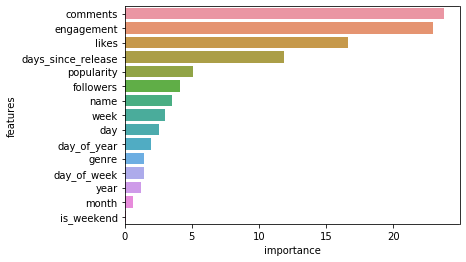

In [50]:
feature_importance = pd.DataFrame(sorted(zip(cbr.feature_importances_, X_train.columns), reverse=True), 
                                  columns=['importance', 'features'])

sns.barplot(x='importance', y='features', data=feature_importance)

In [35]:
import lightgbm as lgb

lgb = lgb.LGBMRegressor()

lgb.fit(X_train, y_train)
y_pred = lgb.predict(X_val)

print(np.sqrt(mean_squared_error(y_val, y_pred)))
print(mean_squared_error(y_val, y_pred))

#leaderboard score: 1346749.15833

1189279.7243978318
1414386262863.7827


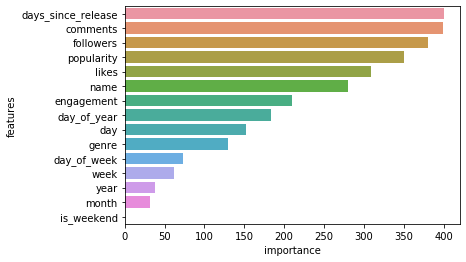

In [36]:
feature_importance = pd.DataFrame(sorted(zip(lgb.feature_importances_, X_train.columns), reverse=True), 
                                  columns=['importance', 'features'])

sns.barplot(x='importance', y='features', data=feature_importance)

In [37]:
df_test = pd.read_csv('data/Data_Test.csv')

df_test['Name'] = pd.factorize(df_test.Name)[0]
df_test['Genre'] = pd.factorize(df_test.Genre)[0]

#df_test = df_test[['Name', 'Genre', 'Timestamp', 'Comments', 'Likes', 'Popularity', 'Followers', 'Views']]

def cleaner(x):
    if ',' in x:
        x = x.replace(',', '')
    elif 'M' in x:
        x = float(x.replace('M', ''))
        x = x*10**6
    elif 'K' in x:
        x = float(x.replace('K', ''))
        x = x*10**3
    return float(x)

df_test.Likes = df_test.Likes.apply(lambda x: cleaner(x))
df_test.Popularity = df_test.Popularity.apply(lambda x: cleaner(x))

#df_test.columns = df_test.columns.str.lower()
df_test.columns = map(str.lower, df_test.columns)

df_test['timestamp'] = pd.to_datetime(df_test.timestamp)

from datetime import datetime
df_test['year'] = df_test.timestamp.dt.year
df_test['month'] = df_test.timestamp.dt.month
df_test['day'] = df_test.timestamp.dt.day
df_test['day_of_year'] = df_test.timestamp.dt.dayofyear
df_test['day_of_week'] = df_test.timestamp.dt.dayofweek
df_test['is_weekend'] = (df_test.timestamp.dt.weekday>=5).astype(int)
df_test['week'] = df_test.timestamp.dt.week
df_test['days_since_release'] = (datetime.now() - df_test.timestamp).dt.days
df_test['engagement'] = df_test.likes + df_test.comments
df_test['engagement_ratio'] = df['engagement'] / df['followers']

df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19615 entries, 0 to 19614
Data columns (total 20 columns):
unique_id             19615 non-null int64
name                  19615 non-null int64
genre                 19615 non-null int64
country               19615 non-null object
song_name             19615 non-null object
timestamp             19615 non-null datetime64[ns]
comments              19615 non-null int64
likes                 19615 non-null float64
popularity            19615 non-null float64
followers             19615 non-null int64
year                  19615 non-null int64
month                 19615 non-null int64
day                   19615 non-null int64
day_of_year           19615 non-null int64
day_of_week           19615 non-null int64
is_weekend            19615 non-null int32
week                  19615 non-null int64
days_since_release    19615 non-null int64
engagement            19615 non-null float64
engagement_ratio      19615 non-null float64
dtypes: date

In [51]:
df_pred = df_test[['name', 'genre', 'comments', 'likes', 'popularity', 'followers', 'year', 'month', 'day', 
                   'day_of_year', 'day_of_week', 'is_weekend', 'week', 'days_since_release', 'engagement']]
y_pred = cbr.predict(df_pred)

In [52]:
sub = pd.DataFrame({'Unique_ID':df_test['unique_id'], 'Views':y_pred})
sub.head()

,Unique_ID,Views
0,562546,288025.218182
1,907584,60074.429067
2,213013,30589.341542
3,340312,33706.652076
4,41854,24035.782242


In [53]:
sub.to_excel('cbr.xlsx')